In [2]:
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap, TwoLocal
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from sklearn.datasets import make_circles, make_moons, make_blobs
from qiskit_machine_learning.datasets import ad_hoc_data

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
from matplotlib import pyplot as plt

from qiskit.circuit import ParameterVector


In [3]:
X_train, y_train, X_test, y_test = ad_hoc_data(
    training_size=70,
    test_size=30,
    n=2,
    gap=0.3,
    one_hot=False)
print(X_train.shape)
print(X_test.shape)


(140, 2)
(60, 2)


Accuracy:  0.5666666666666667


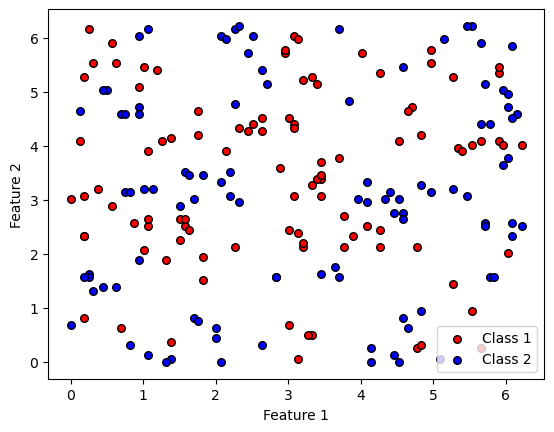

In [12]:
# Change this to change classes and features considered. Don't use class 1 and 2 toghether as they are not linearly separable at all.
class1 = 0
class2 = 1
feature1 = 0
feature2 = 1

X=np.concatenate((X_train, X_test), axis=0)
y=np.concatenate((y_train, y_test), axis=0)

svm = SVC(kernel='rbf') #hard margin C=inf 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))
colors = ['r', 'b']
for i, color in zip([class1, class2], colors):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, label=f'Class {i+1}', edgecolors='k', s=30)

plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.legend()
plt.show()


In [5]:
#Plot decision boundary
w = svm.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X[:, 0].min(), X[:, 0].max())
yy = a * xx - (svm.intercept_[0]) / w[1]
plt.plot(xx, yy, 'black')
#Plot margins
w_hat = svm.coef_[0] / (np.sqrt(np.sum(svm.coef_[0] ** 2)))
margin = 1 / np.sqrt(np.sum(svm.coef_[0] ** 2))
decision_boundary_points = np.array(list(zip(xx, yy)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin
plt.plot(points_of_line_above[:, 0], points_of_line_above[:, 1], 'b--', linewidth=2)
plt.plot(points_of_line_below[:, 0], points_of_line_below[:, 1], 'r--', linewidth=2)
colors = ['r', 'b']
for i, color in zip([class1, class2], colors):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, label=f'Class {i+1}', edgecolors='k', s=30)

plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.legend()
plt.show()

AttributeError: coef_ is only available when using a linear kernel

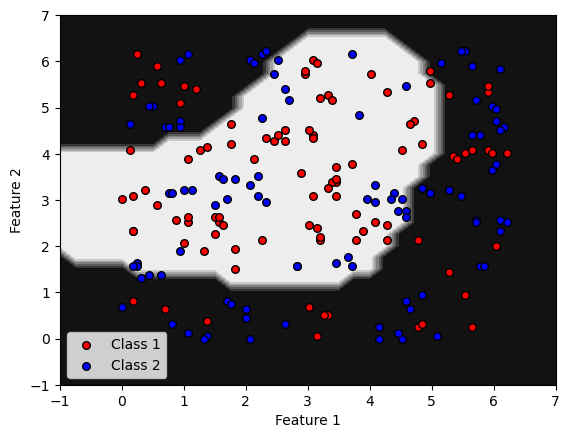

In [13]:
#plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.25), np.arange(y_min, y_max, 0.25))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
colors = ['r', 'b']
for i, color in zip([class1, class2], colors):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, label=f'Class {i+1}', edgecolors='k', s=30)
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.legend()
plt.show()

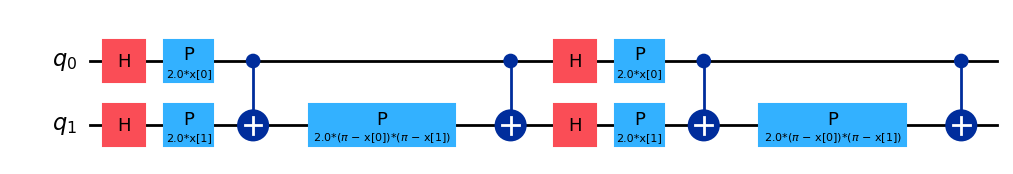

In [14]:
feature_map= ZZFeatureMap(feature_dimension=2)
feature_map.decompose().draw('mpl')

In [15]:
#create quantum kernel
kernel = FidelityQuantumKernel(feature_map=feature_map)

fitted
Accuracy:  1.0


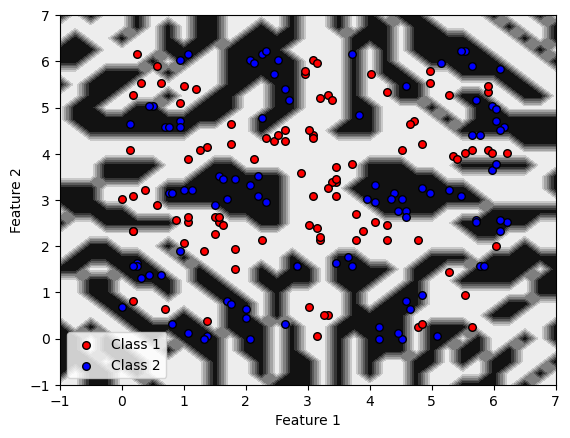

In [16]:
#fit classical SVM
svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X,y)

print('fitted')
print('Accuracy: ', svm.score(X_test, y_test))


#plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.25), np.arange(y_min, y_max, 0.25))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap='binary')
colors = ['r', 'b']
for i, color in zip([class1, class2], colors):
    plt.scatter(X[y == i, 0], X[y == i, 1], color=color, label=f'Class {i+1}', edgecolors='k', s=30)
plt.xlabel(f'Feature {feature1+1}')
plt.ylabel(f'Feature {feature2+1}')
plt.legend()
plt.show()